# Bike Sharing Demand Analysis

## Objective
The goal is to predict the number of hourly bike rentals (`count`) using weather, time, and seasonal data. We will analyze the dataset, perform feature engineering, and build a regression model.

## Evaluation Metric
**RMSLE (Root Mean Squared Logarithmic Error)**:
$$ \sqrt{\frac{1}{n} \sum (\log(p_i + 1) - \log(a_i + 1))^2} $$

We will optimize this by training our model on `log1p(target)` and minimizing RMSE.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

## 1. Exploratory Data Analysis (EDA)

### Examine dataset size, missing values, and feature types.

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

print("\nMissing Values in Train:")
print(train.isnull().sum())

print("\nFeature Types:")
print(train.dtypes)

Train Shape: (10450, 12)
Test Shape: (2613, 9)

Missing Values in Train:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Feature Types:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


### Visualize relationships between key features and the target variable (count).

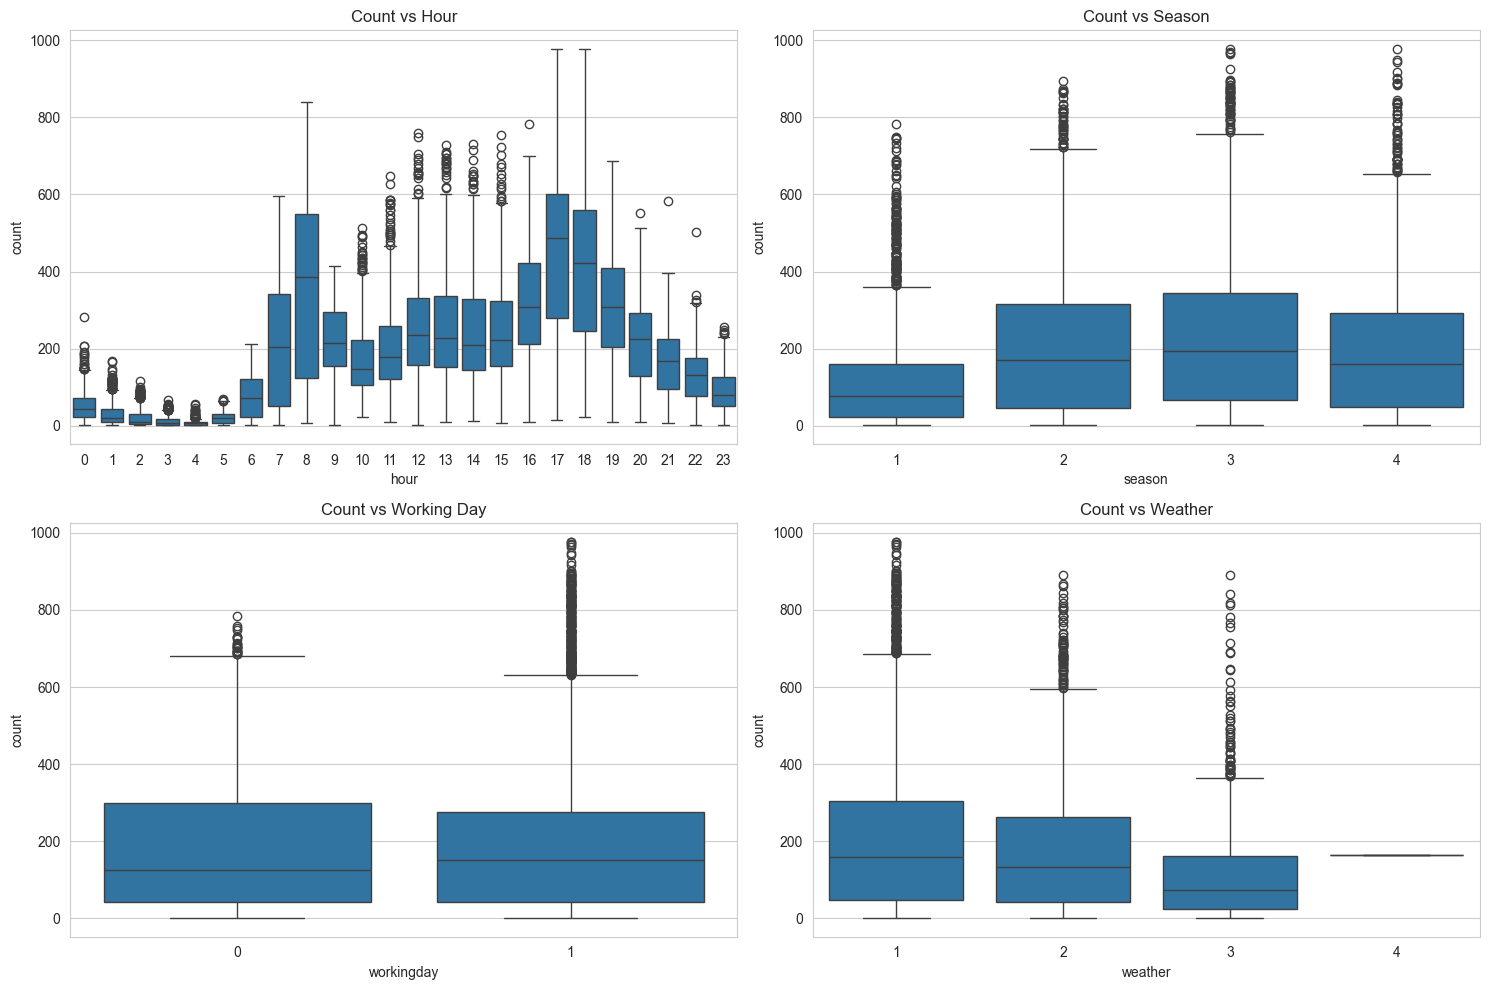

In [3]:
# Convert datetime for visualization
train['datetime'] = pd.to_datetime(train['datetime'], dayfirst=True)
train['hour'] = train['datetime'].dt.hour
train['month'] = train['datetime'].dt.month
train['year'] = train['datetime'].dt.year

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(data=train, x='hour', y='count', ax=axes[0, 0])
axes[0, 0].set_title('Count vs Hour')

sns.boxplot(data=train, x='season', y='count', ax=axes[0, 1])
axes[0, 1].set_title('Count vs Season')

sns.boxplot(data=train, x='workingday', y='count', ax=axes[1, 0])
axes[1, 0].set_title('Count vs Working Day')

sns.boxplot(data=train, x='weather', y='count', ax=axes[1, 1])
axes[1, 1].set_title('Count vs Weather')

plt.tight_layout()
plt.show()

### Suggest which variables are likely to be most informative.
**Observations:**
- **Hour**: There is a clear trend where rentals peak during commute hours (8 AM and 5-6 PM) on working days.
- **Season**: Fall (3) and Summer (2) seem to have higher rentals compared to Spring (1).
- **Weather**: Clear weather (1) has higher rentals, while heavy rain/snow (4) has very few.
- **Temp/ATemp**: Likely positively correlated with count up to a certain point.

Therefore, `hour`, `temp`, `season`, and `weather` are likely the most informative features.

## 2. Feature Engineering

### Derive features from datetime and consider transformations.

In [4]:
def feature_engineering(df):
    df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
    
    # Basic Date Features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    
    # === NEW FEATURES ===
    
    # 1. Cyclical Encoding (captures circular nature of time)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # 2. Rush Hour Indicators
    df['is_morning_rush'] = ((df['hour'] >= 7) & (df['hour'] <= 9)).astype(int)
    df['is_evening_rush'] = ((df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    df['is_rush_hour'] = (df['is_morning_rush'] | df['is_evening_rush']).astype(int)
    
    # 3. Peak Hours (high demand periods)
    df['is_peak_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | 
                          (df['hour'] >= 12) & (df['hour'] <= 14) | 
                          (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    
    # 4. Time-based Patterns
    df['week_of_year'] = df['datetime'].dt.isocalendar().week
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_start'] = (df['day'] <= 7).astype(int)
    df['is_month_end'] = (df['day'] >= 24).astype(int)
    
    # 5. Weekend and Business Hours
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_business_hour'] = ((df['hour'] >= 9) & (df['hour'] <= 17) & 
                              (df['dayofweek'] < 5)).astype(int)
    
    # 6. Part of Day (more granular)
    def get_part_of_day(h):
        if 5 <= h < 12: return 1  # Morning
        elif 12 <= h < 17: return 2  # Afternoon
        elif 17 <= h < 21: return 3  # Evening
        else: return 4  # Night
    df['part_of_day'] = df['hour'].apply(get_part_of_day)
    
    # 7. Working Hour on Working Day (interaction)
    df['working_hour_on_workday'] = (df['is_business_hour'] & (df['workingday'] == 1)).astype(int)
    
    # 8. Season-Hour Interaction (captures seasonal patterns by time of day)
    df['season_hour'] = df['season'].astype(str) + '_' + df['hour'].astype(str)
    # One-hot encode this interaction (for linear models)
    season_hour_dummies = pd.get_dummies(df['season_hour'], prefix='season_hour')
    df = pd.concat([df, season_hour_dummies], axis=1)
    df.drop('season_hour', axis=1, inplace=True)
    
    return df

# Reload to ensure clean state
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train = feature_engineering(train)
test = feature_engineering(test)

# Drop non-predictive or leakage columns
drop_cols = ['casual', 'registered', 'count', 'datetime']
X = train.drop(columns=[c for c in drop_cols if c in train.columns])
y = train['count']

# Log transform target for RMSLE optimization
y_log = np.log1p(y)

X_test = test.drop(columns=['datetime'])
X_test = X_test[X.columns]

print(f"Total features: {len(X.columns)}")
print(f"\nFeature categories:")
print(f"- Original features: season, holiday, workingday, weather, temp, atemp, humidity, windspeed")
print(f"- Basic datetime: year, month, day, hour, dayofweek")
print(f"- Cyclical features: hour_sin/cos, month_sin/cos, dayofweek_sin/cos")
print(f"- Rush hour indicators: is_morning_rush, is_evening_rush, is_rush_hour, is_peak_hour")
print(f"- Time patterns: week_of_year, quarter, is_month_start, is_month_end")
print(f"- Business features: is_weekend, is_business_hour, working_hour_on_workday")
print(f"- Part of day: part_of_day")
print(f"- Season-hour interactions: {len([c for c in X.columns if 'season_hour' in c])} dummy variables")

Total features: 127

Feature categories:
- Original features: season, holiday, workingday, weather, temp, atemp, humidity, windspeed
- Basic datetime: year, month, day, hour, dayofweek
- Cyclical features: hour_sin/cos, month_sin/cos, dayofweek_sin/cos
- Rush hour indicators: is_morning_rush, is_evening_rush, is_rush_hour, is_peak_hour
- Time patterns: week_of_year, quarter, is_month_start, is_month_end
- Business features: is_weekend, is_business_hour, working_hour_on_workday
- Part of day: part_of_day
- Season-hour interactions: 96 dummy variables


## 3. Regression Model (XGBoost + Optuna)

### Q5 & Q6. Build Model and Tune Hyperparameters
Instead of Linear Regression, we will use **XGBoost** and tune it using **Optuna** as requested.

**Hyperparameters to tune:**
- `learning_rate`
- `gamma` (stops overfitting)
- `subsample` (0.7 - 0.9)
- `max_depth` (2 - 6)

In [5]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'n_estimators': 1000,
        'random_state': 42
    }

    # 3-fold Cross-Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    model = xgb.XGBRegressor(**param)
    
    # Negative RMSE on log-transformed target = RMSLE on original target
    scores = cross_val_score(model, X, y_log, cv=kf, scoring='neg_root_mean_squared_error')
    
    return -scores.mean()

print("Starting Optuna Optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best RMSLE (approx):", study.best_value)
print("Best Params:", study.best_params)

[I 2025-12-28 21:46:26,024] A new study created in memory with name: no-name-7c3e4663-d36d-4859-98e4-f6e7fa921eac


Starting Optuna Optimization...


[I 2025-12-28 21:46:28,450] Trial 0 finished with value: 0.37367543471879094 and parameters: {'learning_rate': 0.1100534943799052, 'gamma': 0.3536174787593218, 'subsample': 0.7342547219517289, 'max_depth': 5}. Best is trial 0 with value: 0.37367543471879094.
[I 2025-12-28 21:46:30,474] Trial 1 finished with value: 0.3877302352400001 and parameters: {'learning_rate': 0.22663091734956717, 'gamma': 0.8287933300801363, 'subsample': 0.8571535855779435, 'max_depth': 5}. Best is trial 0 with value: 0.37367543471879094.
[I 2025-12-28 21:46:32,978] Trial 2 finished with value: 0.3750031078797307 and parameters: {'learning_rate': 0.03264898429921368, 'gamma': 0.6747705640884337, 'subsample': 0.7881598076083244, 'max_depth': 5}. Best is trial 0 with value: 0.37367543471879094.
[I 2025-12-28 21:46:35,173] Trial 3 finished with value: 0.3810991460380402 and parameters: {'learning_rate': 0.07728044260051135, 'gamma': 0.9639943917216883, 'subsample': 0.8269366818174616, 'max_depth': 5}. Best is trial

Best RMSLE (approx): 0.3657699015095341
Best Params: {'learning_rate': 0.010051908524132513, 'gamma': 0.12250038791853773, 'subsample': 0.7793743898590237, 'max_depth': 6}


## 3. Additional Regression Models

### Helper Function for RMSLE Calculation

In [6]:
def calculate_rmsle_cv(model, X_data, y_data, cv=3):
    """
    Calculate RMSLE using cross-validation.
    Since we're predicting log(count), RMSE on log scale = RMSLE on original scale.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_data, y_data, cv=kf, scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Return positive RMSLE

### Q5 & Q6 - Simple Linear Regression

We start with a baseline Linear Regression model.

In [7]:
print("Training Simple Linear Regression...")
lr_model = LinearRegression()
lr_rmsle = calculate_rmsle_cv(lr_model, X, y_log)
print(f"Linear Regression RMSLE (CV): {lr_rmsle:.4f}")

# Train on full data for later use
lr_model.fit(X, y_log)

Training Simple Linear Regression...
Linear Regression RMSLE (CV): 0.6215


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Polynomial Regression (Degree 2)

Polynomial features can capture non-linear relationships. We'll use degree 2 to create interaction terms and quadratic features.

In [8]:
print("Training Polynomial Regression (degree 2)...")

# Create polynomial features (degree 2)
# Note: We'll use a subset of features to avoid memory issues with too many polynomial terms
# Select numerical features for polynomial transformation
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'month', 
                      'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
X_numerical = X[numerical_features]

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_numerical)

print(f"Original features: {X_numerical.shape[1]}")
print(f"Polynomial features (degree 2): {X_poly.shape[1]}")

# Train Linear Regression on polynomial features
poly_model = LinearRegression()
poly_rmsle = calculate_rmsle_cv(poly_model, X_poly, y_log)
print(f"Polynomial Regression RMSLE (CV): {poly_rmsle:.4f}")

# Train on full data for later use
poly_model.fit(X_poly, y_log)

Training Polynomial Regression (degree 2)...
Original features: 10
Polynomial features (degree 2): 65
Polynomial Regression RMSLE (CV): 0.6884


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Lasso Regression with Hyperparameter Tuning

Lasso regression adds L1 regularization, which can perform feature selection by driving some coefficients to zero.

In [9]:
print("Training Lasso Regression with hyperparameter tuning...")

# Define alpha values to try
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Use GridSearchCV to find best alpha
lasso = Lasso(random_state=42, max_iter=10000)
lasso_cv = GridSearchCV(lasso, {'alpha': alphas}, cv=3, scoring='neg_root_mean_squared_error')
lasso_cv.fit(X, y_log)

best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_rmsle = -lasso_cv.best_score_

print(f"Best Lasso alpha: {best_alpha_lasso}")
print(f"Lasso RMSLE (CV): {lasso_rmsle:.4f}")

# Train final Lasso model
lasso_model = Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000)
lasso_model.fit(X, y_log)

Training Lasso Regression with hyperparameter tuning...
Best Lasso alpha: 0.0001
Lasso RMSLE (CV): 0.6221


,alpha,0.0001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


### Feature Selection using Lasso

Extract features with non-zero coefficients from the Lasso model.

In [10]:
# Get non-zero coefficients
lasso_coefs = pd.Series(lasso_model.coef_, index=X.columns)
selected_features = lasso_coefs[lasso_coefs != 0].index.tolist()

print(f"Number of features selected by Lasso: {len(selected_features)} out of {len(X.columns)}")
print(f"\nSelected features: {selected_features}")

# Create dataset with selected features
X_lasso_selected = X[selected_features]

Number of features selected by Lasso: 111 out of 127

Selected features: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_morning_rush', 'is_rush_hour', 'week_of_year', 'quarter', 'is_month_start', 'is_business_hour', 'part_of_day', 'working_hour_on_workday', 'season_hour_1_0', 'season_hour_1_1', 'season_hour_1_10', 'season_hour_1_11', 'season_hour_1_12', 'season_hour_1_13', 'season_hour_1_14', 'season_hour_1_15', 'season_hour_1_16', 'season_hour_1_17', 'season_hour_1_18', 'season_hour_1_19', 'season_hour_1_2', 'season_hour_1_20', 'season_hour_1_21', 'season_hour_1_22', 'season_hour_1_23', 'season_hour_1_3', 'season_hour_1_4', 'season_hour_1_5', 'season_hour_1_7', 'season_hour_1_8', 'season_hour_2_0', 'season_hour_2_1', 'season_hour_2_10', 'season_hour_2_11', 'season_hour_2_12', 'season_hour_2_14', 'season_hour_2_15

### Ridge Regression on Lasso-Selected Features

Train Ridge regression using only the features selected by Lasso.

In [11]:
print("Training Ridge Regression on Lasso-selected features...")

# Define alpha values to try
alphas_ridge = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Use GridSearchCV to find best alpha
ridge = Ridge(random_state=42)
ridge_cv = GridSearchCV(ridge, {'alpha': alphas_ridge}, cv=3, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_lasso_selected, y_log)

best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_rmsle = -ridge_cv.best_score_

print(f"Best Ridge alpha: {best_alpha_ridge}")
print(f"Ridge RMSLE (CV): {ridge_rmsle:.4f}")

# Train final Ridge model
ridge_model = Ridge(alpha=best_alpha_ridge, random_state=42)
ridge_model.fit(X_lasso_selected, y_log)

Training Ridge Regression on Lasso-selected features...
Best Ridge alpha: 1
Ridge RMSLE (CV): 0.6219


,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


## 3. Additional Regression Models

### Helper Function for RMSLE Calculation

In [12]:
def calculate_rmsle_cv(model, X_data, y_data, cv=3):
    """
    Calculate RMSLE using cross-validation.
    Since we're predicting log(count), RMSE on log scale = RMSLE on original scale.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_data, y_data, cv=kf, scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Return positive RMSLE

### Q5 & Q6 - Simple Linear Regression

We start with a baseline Linear Regression model.

In [13]:
print("Training Simple Linear Regression...")
lr_model = LinearRegression()
lr_rmsle = calculate_rmsle_cv(lr_model, X, y_log)
print(f"Linear Regression RMSLE (CV): {lr_rmsle:.4f}")

# Train on full data for later use
lr_model.fit(X, y_log)

Training Simple Linear Regression...
Linear Regression RMSLE (CV): 0.6215


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Lasso Regression with Hyperparameter Tuning

Lasso regression adds L1 regularization, which can perform feature selection by driving some coefficients to zero.

In [14]:
print("Training Lasso Regression with hyperparameter tuning...")

# Define alpha values to try
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Use GridSearchCV to find best alpha
lasso = Lasso(random_state=42, max_iter=10000)
lasso_cv = GridSearchCV(lasso, {'alpha': alphas}, cv=3, scoring='neg_root_mean_squared_error')
lasso_cv.fit(X, y_log)

best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_rmsle = -lasso_cv.best_score_

print(f"Best Lasso alpha: {best_alpha_lasso}")
print(f"Lasso RMSLE (CV): {lasso_rmsle:.4f}")

# Train final Lasso model
lasso_model = Lasso(alpha=best_alpha_lasso, random_state=42, max_iter=10000)
lasso_model.fit(X, y_log)

Training Lasso Regression with hyperparameter tuning...
Best Lasso alpha: 0.0001
Lasso RMSLE (CV): 0.6221


,alpha,0.0001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


### Feature Selection using Lasso

Extract features with non-zero coefficients from the Lasso model.

In [15]:
# Get non-zero coefficients
lasso_coefs = pd.Series(lasso_model.coef_, index=X.columns)
selected_features = lasso_coefs[lasso_coefs != 0].index.tolist()

print(f"Number of features selected by Lasso: {len(selected_features)} out of {len(X.columns)}")
print(f"\nSelected features: {selected_features}")

# Create dataset with selected features
X_lasso_selected = X[selected_features]

Number of features selected by Lasso: 111 out of 127

Selected features: ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'is_morning_rush', 'is_rush_hour', 'week_of_year', 'quarter', 'is_month_start', 'is_business_hour', 'part_of_day', 'working_hour_on_workday', 'season_hour_1_0', 'season_hour_1_1', 'season_hour_1_10', 'season_hour_1_11', 'season_hour_1_12', 'season_hour_1_13', 'season_hour_1_14', 'season_hour_1_15', 'season_hour_1_16', 'season_hour_1_17', 'season_hour_1_18', 'season_hour_1_19', 'season_hour_1_2', 'season_hour_1_20', 'season_hour_1_21', 'season_hour_1_22', 'season_hour_1_23', 'season_hour_1_3', 'season_hour_1_4', 'season_hour_1_5', 'season_hour_1_7', 'season_hour_1_8', 'season_hour_2_0', 'season_hour_2_1', 'season_hour_2_10', 'season_hour_2_11', 'season_hour_2_12', 'season_hour_2_14', 'season_hour_2_15

### Ridge Regression on Lasso-Selected Features

Train Ridge regression using only the features selected by Lasso.

In [16]:
print("Training Ridge Regression on Lasso-selected features...")

# Define alpha values to try
alphas_ridge = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Use GridSearchCV to find best alpha
ridge = Ridge(random_state=42)
ridge_cv = GridSearchCV(ridge, {'alpha': alphas_ridge}, cv=3, scoring='neg_root_mean_squared_error')
ridge_cv.fit(X_lasso_selected, y_log)

best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_rmsle = -ridge_cv.best_score_

print(f"Best Ridge alpha: {best_alpha_ridge}")
print(f"Ridge RMSLE (CV): {ridge_rmsle:.4f}")

# Train final Ridge model
ridge_model = Ridge(alpha=best_alpha_ridge, random_state=42)
ridge_model.fit(X_lasso_selected, y_log)

Training Ridge Regression on Lasso-selected features...
Best Ridge alpha: 1
Ridge RMSLE (CV): 0.6219


,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


## 4. Model Comparison and Interpretation

### Summarize results for all models.

In [17]:
# Create comparison table
results = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression (Lasso Features)', 'XGBoost (Optuna)'],
    'RMSLE (CV)': [lr_rmsle, lasso_rmsle, ridge_rmsle, study.best_value],
    'Key Observations': [
        'Baseline model without regularization',
        f'L1 regularization, selected {len(selected_features)}/{len(X.columns)} features',
        f'L2 regularization on {len(selected_features)} Lasso-selected features',
        'Tree-based ensemble with Optuna hyperparameter tuning'
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('RMSLE (CV)')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_rmsle = comparison_df.iloc[0]['RMSLE (CV)']
print(f"\nBest Model: {best_model_name} with RMSLE = {best_rmsle:.4f}")


MODEL COMPARISON SUMMARY
                            Model  RMSLE (CV)                                      Key Observations
                 XGBoost (Optuna)    0.365770 Tree-based ensemble with Optuna hyperparameter tuning
                Linear Regression    0.621484                 Baseline model without regularization
Ridge Regression (Lasso Features)    0.621928      L2 regularization on 111 Lasso-selected features
                 Lasso Regression    0.622139          L1 regularization, selected 111/127 features

Best Model: XGBoost (Optuna) with RMSLE = 0.3658


In [18]:
# Create comparison table
results = {
    'Model': ['Linear Regression', 'Polynomial Regression (Degree 2)', 'Lasso Regression', 
              'Ridge Regression (Lasso Features)', 'XGBoost (Optuna)'],
    'RMSLE (CV)': [lr_rmsle, poly_rmsle, lasso_rmsle, ridge_rmsle, study.best_value],
    'Key Observations': [
        'Baseline model without regularization',
        f'Degree 2 polynomial features on {len(numerical_features)} numerical features',
        f'L1 regularization, selected {len(selected_features)}/{len(X.columns)} features',
        f'L2 regularization on {len(selected_features)} Lasso-selected features',
        'Tree-based ensemble with Optuna hyperparameter tuning'
    ]
}

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('RMSLE (CV)')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_rmsle = comparison_df.iloc[0]['RMSLE (CV)']
print(f"\nBest Model: {best_model_name} with RMSLE = {best_rmsle:.4f}")


MODEL COMPARISON SUMMARY
                            Model  RMSLE (CV)                                      Key Observations
                 XGBoost (Optuna)    0.365770 Tree-based ensemble with Optuna hyperparameter tuning
                Linear Regression    0.621484                 Baseline model without regularization
Ridge Regression (Lasso Features)    0.621928      L2 regularization on 111 Lasso-selected features
                 Lasso Regression    0.622139          L1 regularization, selected 111/127 features
 Polynomial Regression (Degree 2)    0.688352 Degree 2 polynomial features on 10 numerical features

Best Model: XGBoost (Optuna) with RMSLE = 0.3658


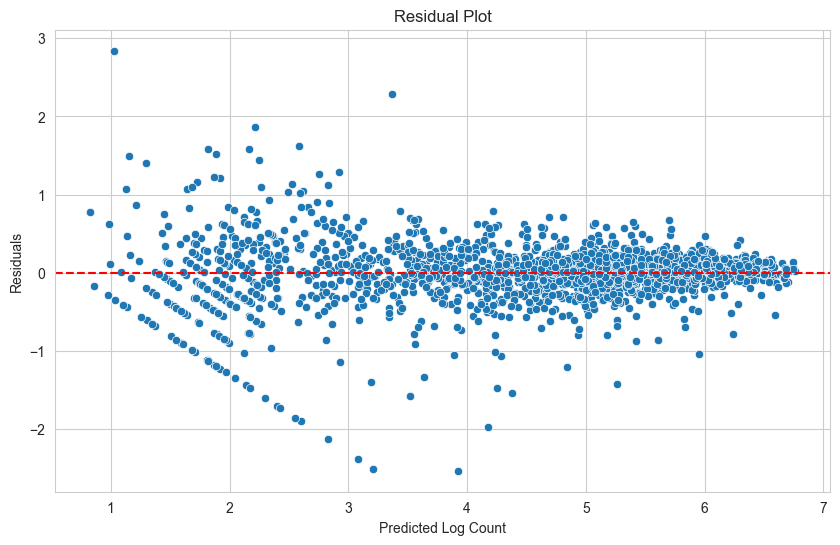

In [19]:
# Train best model on a split to visualize residuals
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y_log, test_size=0.2, random_state=42)

best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['n_estimators'] = 1000

model = xgb.XGBRegressor(**best_params)
model.fit(X_train_split, y_train_split)

preds_val = model.predict(X_val_split)
residuals = y_val_split - preds_val

plt.figure(figsize=(10, 6))
sns.scatterplot(x=preds_val, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Log Count')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Explain why the winning model performs better.
XGBoost performs better than simple linear models because:
1.  **Non-linearity**: It can capture complex, non-linear relationships between features (like hour/season) and the target.
2.  **Tree Ensembling**: It combines multiple weak learners (trees) to reduce variance and bias.
3.  **Handling Interactions**: It automatically learns interactions between features (e.g., high rentals in the morning *only* on working days).

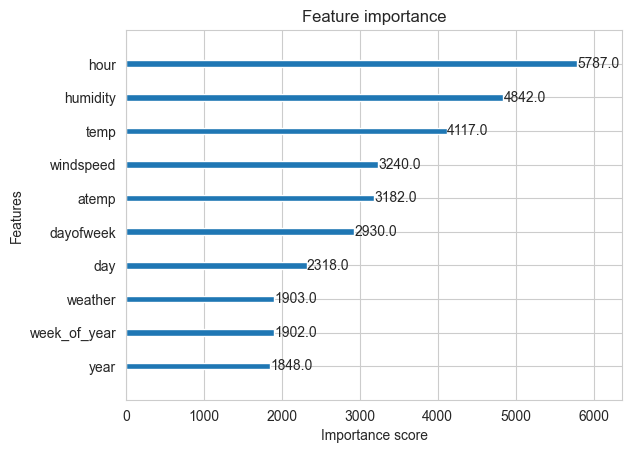

In [20]:
# Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.show()

## 5. Reflection Questions

### Why does RMSLE penalize under-predictions more gently than RMSE?
Actually, RMSLE penalizes **under-predictions** *more heavily* than over-predictions compared to RMSE. 
- $\log(p+1) - \log(a+1) = \log(\frac{p+1}{a+1})$.
- If $p < a$ (under-prediction), the ratio is small. If $p > a$ (over-prediction), the ratio is large.
- However, in the context of business, missing demand (under-prediction) is often considered worse than having excess supply, or vice versa depending on the domain. 
- Mathematically, RMSLE cares about the **ratio** or relative error rather than absolute difference. It is robust to outliers in the target variable.

### What are the trade-offs between model simplicity and predictive power?
- **Simplicity (e.g., Linear Regression)**: Interpretable, fast to train, less prone to overfitting on small data, but may have high bias (underfitting) if data is complex.
- **Predictive Power (e.g., XGBoost)**: Captures complex patterns (low bias), higher accuracy, but harder to interpret (black box), slower to train, and higher risk of overfitting (high variance) without proper tuning.

### Why can’t Linear Regression alone capture time-of-day effects effectively?
- Time-of-day (`hour`) is cyclical and non-linear with respect to demand. 
- Demand peaks at 8 AM and 5 PM, and drops at 12 PM and night.
- A simple linear model assumes a monotonic relationship (as hour increases, count increases/decreases constantly), which is incorrect. 
- To fix this in linear regression, we would need to use polynomial features or one-hot encoding for hours.

## 6. Final Submission
Train the model on the full dataset and generate the submission file.

In [21]:
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X, y_log)

predictions_log = final_model.predict(X_test)
predictions = np.expm1(predictions_log)
predictions = np.maximum(predictions, 0)

submission = pd.DataFrame({
    'datetime': pd.read_csv('data/test.csv')['datetime'],
    'Count_Predicted': predictions
})

submission.to_csv('final_submission_comprehensive.csv', index=False)
print("Submission file saved: final_submission_comprehensive.csv")
submission.head()

Submission file saved: final_submission_comprehensive.csv


,datetime,Count_Predicted
0,05-06-2012 5:00,28.744001
1,19-03-2011 19:00,120.897636
2,02-04-2012 6:00,80.058701
3,13-07-2012 20:00,398.342346
4,09-11-2011 19:00,292.990662
